In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [ ]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (201158, 2) (49582, 2)
train/valid # (201158, 2) (49582, 2)
rand split across time
train has 201158 records out of 389630 records
valid has 49582 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1571
0
(201158, 1, 36) (201158, 7, 32) (201158, 1) (201158, 1)
(201158, 260) (201158,) (201158,)
(49582, 1, 36) (49582, 7, 32) (49582, 1) (49582, 1)
(49582, 260) (49582,) (49582,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40132	valid-rmse:2.36321
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985851	valid-rmse:0.973978
[100]	train-rmse:0.574082	valid-rmse:0.579873
[150]	train-rmse:0.489425	valid-rmse:0.505871
[200]	train-rmse:0.473016	valid-rmse:0.495399
[250]	train-rmse:0.46741	valid-rmse:0.494169
[300]	train-rmse:0.463709	valid-rmse:0.494078
Stopping. Best iteration:
[290]	train-rmse:0.464299	valid-rmse:0.494042

0.21557306 0.2440775
[0.2440775]
-1 mean score 0.2440775
0.192171022296


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919061  0.010049  0.203334    7  2017-04-16
472     2.507290  2.529500 -0.022210  0.207781    1  2017-04-17
473     2.661330  2.661327  0.000003  0.220655    2  2017-04-18
474     2.754815  2.739931  0.014883  0.186964    3  2017-04-19
475     2.713762  2.708043  0.005719  0.210387    4  2017-04-20
476     2.999000  2.977334  0.021666  0.143551    5  2017-04-21
477     3.075529  3.074930  0.000599  0.172525    6  2017-04-22

0.192171022296


pred         y     error    error2  day        date
dayidx                                                         
471     2.919061  2.929110  0.010049  0.203334    7  2017-04-16
472     2.529500  2.507290 -0.022210  0.207781    1  2017-04-17
473     2.661327  2.661330  0.000003  0.220655    2  2017-04-18
474     2.739931  2.754815  0.014883  0.186964    3  2017-04-19
475     2.708043  2.713762  0.005719  0.210387    4  2017-04-20
476     2.977334  2.999000  0.021666  0.143551    5  2017-04-21
477     3.074930  3.075529  0.000599  0.172525    6  2017-04-22

(829, 260)


In [ ]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200932, 2) (49525, 2)
train/valid # (200932, 2) (49525, 2)
rand split across time
train has 200932 records out of 389630 records
valid has 49525 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1569
0
(200932, 1, 36) (200932, 7, 32) (200932, 1) (200932, 1)
(200932, 260) (200932,) (200932,)
(49525, 1, 36) (49525, 7, 32) (49525, 1) (49525, 1)
(49525, 260) (49525,) (49525,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40112	valid-rmse:2.36294
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98824	valid-rmse:0.977461
[100]	train-rmse:0.578568	valid-rmse:0.586426
[150]	train-rmse:0.494759	valid-rmse:0.513705
[200]	train-rmse:0.478894	valid-rmse:0.503545
[250]	train-rmse:0.473806	valid-rmse:0.502473
[300]	train-rmse:0.470086	valid-rmse:0.502473
Stopping. Best iteration:
[270]	train-rmse:0.472152	valid-rmse:0.502395

0.22292757 0.25240085
[0.25240085]
-1 mean score 0.25240085
0.198772743344


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908366  0.020744  0.212454    7  2017-04-16
472     2.507290  2.525450 -0.018160  0.211368    1  2017-04-17
473     2.661330  2.648490  0.012840  0.227714    2  2017-04-18
474     2.754815  2.735090  0.019725  0.195811    3  2017-04-19
475     2.713762  2.708280  0.005481  0.223091    4  2017-04-20
476     2.999000  2.984522  0.014477  0.149420    5  2017-04-21
477     3.075529  3.062442  0.013087  0.171551    6  2017-04-22

0.198772743344


pred         y     error    error2  day        date
dayidx                                                         
471     2.908366  2.929110  0.020744  0.212454    7  2017-04-16
472     2.525450  2.507290 -0.018160  0.211368    1  2017-04-17
473     2.648490  2.661330  0.012840  0.227714    2  2017-04-18
474     2.735090  2.754815  0.019725  0.195811    3  2017-04-19
475     2.708280  2.713762  0.005481  0.223091    4  2017-04-20
476     2.984522  2.999000  0.014477  0.149420    5  2017-04-21
477     3.062442  3.075529  0.013087  0.171551    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200747, 2) (49483, 2)
train/valid # (200747, 2) (49483, 2)
rand split across time
train has 200747 records out of 389630 records
valid has 49483 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1568
0
(200747, 1, 36) (200747, 7, 32) (200747, 1) (200747, 1)
(200747, 260) (200747,) (200747,)
(49483, 1, 36) (49483, 7, 32) (49483, 1) (49483, 1)
(49483, 260) (49483,) (49483,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4009	valid-rmse:2.3628
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989162	valid-rmse:0.976424
[100]	train-rmse:0.580464	valid-rmse:0.586238
[150]	train-rmse:0.497003	valid-rmse:0.514398
[200]	train-rmse:0.481084	valid-rmse:0.504851
[250]	train-rmse:0.475962	valid-rmse:0.504016
Stopping. Best iteration:
[246]	train-rmse:0.476296	valid-rmse:0.504

0.22685803 0.25401607
[0.25401607]
-1 mean score 0.25401607
0.204272225499


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888673  0.040437  0.219652    7  2017-04-16
472     2.507290  2.517782 -0.010491  0.217960    1  2017-04-17
473     2.661330  2.636523  0.024807  0.241542    2  2017-04-18
474     2.754815  2.741444  0.013371  0.200377    3  2017-04-19
475     2.713762  2.701228  0.012534  0.222886    4  2017-04-20
476     2.999000  2.979920  0.019080  0.150787    5  2017-04-21
477     3.075529  3.056069  0.019460  0.176702    6  2017-04-22

0.204272225499


pred         y     error    error2  day        date
dayidx                                                         
471     2.888673  2.929110  0.040437  0.219652    7  2017-04-16
472     2.517782  2.507290 -0.010491  0.217960    1  2017-04-17
473     2.636523  2.661330  0.024807  0.241542    2  2017-04-18
474     2.741444  2.754815  0.013371  0.200377    3  2017-04-19
475     2.701228  2.713762  0.012534  0.222886    4  2017-04-20
476     2.979920  2.999000  0.019080  0.150787    5  2017-04-21
477     3.056069  3.075529  0.019460  0.176702    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200584, 2) (49444, 2)
train/valid # (200584, 2) (49444, 2)
rand split across time
train has 200584 records out of 389630 records
valid has 49444 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1567
0
(200584, 1, 36) (200584, 7, 32) (200584, 1) (200584, 1)
(200584, 260) (200584,) (200584,)
(49444, 1, 36) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 260) (49444,) (49444,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4009	valid-rmse:2.36274
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989679	valid-rmse:0.980884
[100]	train-rmse:0.581664	valid-rmse:0.591065
[150]	train-rmse:0.498512	valid-rmse:0.517779
[200]	train-rmse:0.482897	valid-rmse:0.507368
[250]	train-rmse:0.477605	valid-rmse:0.506074
[300]	train-rmse:0.473711	valid-rmse:0.505972
[350]	train-rmse:0.470576	valid-rmse:0.505988
Stopping. Best iteration:
[310]	train-rmse:0.473049	valid-rmse:0.505948

0.22377503 0.25598362
[0.25598362]
-1 mean score 0.25598362
0.198918223381


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900927  0.028183  0.216154    7  2017-04-16
472     2.507290  2.517529 -0.010238  0.212278    1  2017-04-17
473     2.661330  2.636053  0.025276  0.225610    2  2017-04-18
474     2.754815  2.736580  0.018235  0.197081    3  2017-04-19
475     2.713762  2.710786  0.002976  0.219502    4  2017-04-20
476     2.999000  2.976793  0.022207  0.149345    5  2017-04-21
477     3.075529  3.065342  0.010187  0.172457    6  2017-04-22

0.198918223381


pred         y     error    error2  day        date
dayidx                                                         
471     2.900927  2.929110  0.028183  0.216154    7  2017-04-16
472     2.517529  2.507290 -0.010238  0.212278    1  2017-04-17
473     2.636053  2.661330  0.025276  0.225610    2  2017-04-18
474     2.736580  2.754815  0.018235  0.197081    3  2017-04-19
475     2.710786  2.713762  0.002976  0.219502    4  2017-04-20
476     2.976793  2.999000  0.022207  0.149345    5  2017-04-21
477     3.065342  3.075529  0.010187  0.172457    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200384, 2) (49392, 2)
train/valid # (200384, 2) (49392, 2)
rand split across time
train has 200384 records out of 389630 records
valid has 49392 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1565
0
(200384, 1, 36) (200384, 7, 32) (200384, 1) (200384, 1)
(200384, 260) (200384,) (200384,)
(49392, 1, 36) (49392, 7, 32) (49392, 1) (49392, 1)
(49392, 260) (49392,) (49392,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40116	valid-rmse:2.3629
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990427	valid-rmse:0.978514
[100]	train-rmse:0.582488	valid-rmse:0.589761
[150]	train-rmse:0.499165	valid-rmse:0.518346
[200]	train-rmse:0.483101	valid-rmse:0.508893
[250]	train-rmse:0.478093	valid-rmse:0.507981
[300]	train-rmse:0.474498	valid-rmse:0.507989
Stopping. Best iteration:
[285]	train-rmse:0.475297	valid-rmse:0.507956

0.22590676 0.25801966
[0.25801966]
-1 mean score 0.25801966
0.20173406601


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895916  0.033194  0.216906    7  2017-04-16
472     2.507290  2.520812 -0.013522  0.217324    1  2017-04-17
473     2.661330  2.624731  0.036599  0.232322    2  2017-04-18
474     2.754815  2.730146  0.024669  0.196652    3  2017-04-19
475     2.713762  2.704219  0.009543  0.222004    4  2017-04-20
476     2.999000  2.974726  0.024273  0.154444    5  2017-04-21
477     3.075529  3.063217  0.012312  0.172486    6  2017-04-22

0.20173406601


pred         y     error    error2  day        date
dayidx                                                         
471     2.895916  2.929110  0.033194  0.216906    7  2017-04-16
472     2.520812  2.507290 -0.013522  0.217324    1  2017-04-17
473     2.624731  2.661330  0.036599  0.232322    2  2017-04-18
474     2.730146  2.754815  0.024669  0.196652    3  2017-04-19
475     2.704219  2.713762  0.009543  0.222004    4  2017-04-20
476     2.974726  2.999000  0.024273  0.154444    5  2017-04-21
477     3.063217  3.075529  0.012312  0.172486    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200174, 2) (49339, 2)
train/valid # (200174, 2) (49339, 2)
rand split across time
train has 200174 records out of 389630 records
valid has 49339 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1563
0
(200174, 1, 36) (200174, 7, 32) (200174, 1) (200174, 1)
(200174, 260) (200174,) (200174,)
(49339, 1, 36) (49339, 7, 32) (49339, 1) (49339, 1)
(49339, 260) (49339,) (49339,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40135	valid-rmse:2.36292
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991054	valid-rmse:0.984787
[100]	train-rmse:0.58395	valid-rmse:0.595575
[150]	train-rmse:0.500997	valid-rmse:0.521325
[200]	train-rmse:0.485149	valid-rmse:0.510437
[250]	train-rmse:0.479837	valid-rmse:0.508946
[300]	train-rmse:0.47629	valid-rmse:0.508828
[350]	train-rmse:0.473974	valid-rmse:0.508908
Stopping. Best iteration:
[303]	train-rmse:0.476105	valid-rmse:0.508817

0.2266759 0.2588946
[0.2588946]
-1 mean score 0.2588946
0.203944697976


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907163  0.021947  0.222544    7  2017-04-16
472     2.507290  2.528400 -0.021110  0.221324    1  2017-04-17
473     2.661330  2.632013  0.029316  0.235004    2  2017-04-18
474     2.754815  2.730978  0.023837  0.197631    3  2017-04-19
475     2.713762  2.710540  0.003222  0.224654    4  2017-04-20
476     2.999000  2.966798  0.032202  0.153035    5  2017-04-21
477     3.075529  3.074549  0.000980  0.173420    6  2017-04-22

0.203944697976


pred         y     error    error2  day        date
dayidx                                                         
471     2.907163  2.929110  0.021947  0.222544    7  2017-04-16
472     2.528400  2.507290 -0.021110  0.221324    1  2017-04-17
473     2.632013  2.661330  0.029316  0.235004    2  2017-04-18
474     2.730978  2.754815  0.023837  0.197631    3  2017-04-19
475     2.710540  2.713762  0.003222  0.224654    4  2017-04-20
476     2.966798  2.999000  0.032202  0.153035    5  2017-04-21
477     3.074549  3.075529  0.000980  0.173420    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199954, 2) (49285, 2)
train/valid # (199954, 2) (49285, 2)
rand split across time
train has 199954 records out of 389630 records
valid has 49285 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1562
0
(199954, 1, 36) (199954, 7, 32) (199954, 1) (199954, 1)
(199954, 260) (199954,) (199954,)
(49285, 1, 36) (49285, 7, 32) (49285, 1) (49285, 1)
(49285, 260) (49285,) (49285,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4015	valid-rmse:2.36287
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991886	valid-rmse:0.981586
[100]	train-rmse:0.585119	valid-rmse:0.593979
[150]	train-rmse:0.502249	valid-rmse:0.522219
[200]	train-rmse:0.486463	valid-rmse:0.512322
[250]	train-rmse:0.481163	valid-rmse:0.511221
[300]	train-rmse:0.477356	valid-rmse:0.511197
Stopping. Best iteration:
[283]	train-rmse:0.478394	valid-rmse:0.511169

0.22886047 0.26129407
[0.26129407]
-1 mean score 0.26129407
0.205671995878


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902097  0.027012  0.222061    7  2017-04-16
472     2.507290  2.538751 -0.031460  0.225123    1  2017-04-17
473     2.661330  2.638581  0.022748  0.240062    2  2017-04-18
474     2.754815  2.723540  0.031275  0.200090    3  2017-04-19
475     2.713762  2.704139  0.009622  0.223296    4  2017-04-20
476     2.999000  2.973396  0.025603  0.151667    5  2017-04-21
477     3.075529  3.082212 -0.006683  0.177405    6  2017-04-22

0.205671995878


pred         y     error    error2  day        date
dayidx                                                         
471     2.902097  2.929110  0.027012  0.222061    7  2017-04-16
472     2.538751  2.507290 -0.031460  0.225123    1  2017-04-17
473     2.638581  2.661330  0.022748  0.240062    2  2017-04-18
474     2.723540  2.754815  0.031275  0.200090    3  2017-04-19
475     2.704139  2.713762  0.009622  0.223296    4  2017-04-20
476     2.973396  2.999000  0.025603  0.151667    5  2017-04-21
477     3.082212  3.075529 -0.006683  0.177405    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199722, 2) (49227, 2)
train/valid # (199722, 2) (49227, 2)
rand split across time
train has 199722 records out of 389630 records
valid has 49227 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1560
0
(199722, 1, 36) (199722, 7, 32) (199722, 1) (199722, 1)
(199722, 260) (199722,) (199722,)
(49227, 1, 36) (49227, 7, 32) (49227, 1) (49227, 1)
(49227, 260) (49227,) (49227,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40143	valid-rmse:2.36265
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993449	valid-rmse:0.981181
[100]	train-rmse:0.587987	valid-rmse:0.595149
[150]	train-rmse:0.505505	valid-rmse:0.524691
[200]	train-rmse:0.489524	valid-rmse:0.515379
[250]	train-rmse:0.484104	valid-rmse:0.51447
[300]	train-rmse:0.480292	valid-rmse:0.514545
Stopping. Best iteration:
[266]	train-rmse:0.482839	valid-rmse:0.514449

0.23313352 0.26465786
[0.26465786]
-1 mean score 0.26465786
0.211132317781


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909658  0.019451  0.233426    7  2017-04-16
472     2.507290  2.534150 -0.026859  0.223720    1  2017-04-17
473     2.661330  2.639616  0.021714  0.245212    2  2017-04-18
474     2.754815  2.727153  0.027662  0.209833    3  2017-04-19
475     2.713762  2.706199  0.007562  0.228916    4  2017-04-20
476     2.999000  2.961078  0.037921  0.159279    5  2017-04-21
477     3.075529  3.079876 -0.004347  0.177539    6  2017-04-22

0.211132317781


pred         y     error    error2  day        date
dayidx                                                         
471     2.909658  2.929110  0.019451  0.233426    7  2017-04-16
472     2.534150  2.507290 -0.026859  0.223720    1  2017-04-17
473     2.639616  2.661330  0.021714  0.245212    2  2017-04-18
474     2.727153  2.754815  0.027662  0.209833    3  2017-04-19
475     2.706199  2.713762  0.007562  0.228916    4  2017-04-20
476     2.961078  2.999000  0.037921  0.159279    5  2017-04-21
477     3.079876  3.075529 -0.004347  0.177539    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199495, 2) (49172, 2)
train/valid # (199495, 2) (49172, 2)
rand split across time
train has 199495 records out of 389630 records
valid has 49172 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1558
0
(199495, 1, 36) (199495, 7, 32) (199495, 1) (199495, 1)
(199495, 260) (199495,) (199495,)
(49172, 1, 36) (49172, 7, 32) (49172, 1) (49172, 1)
(49172, 260) (49172,) (49172,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40115	valid-rmse:2.36241
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994461	valid-rmse:0.983695
[100]	train-rmse:0.590083	valid-rmse:0.598328
[150]	train-rmse:0.507894	valid-rmse:0.52727
[200]	train-rmse:0.491916	valid-rmse:0.517476
[250]	train-rmse:0.486563	valid-rmse:0.51643
[300]	train-rmse:0.482739	valid-rmse:0.516501
Stopping. Best iteration:
[270]	train-rmse:0.485006	valid-rmse:0.516361

0.23523115 0.2666291
[0.2666291]
-1 mean score 0.2666291
0.211897149682


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907777  0.021333  0.233857    7  2017-04-16
472     2.507290  2.540539 -0.033248  0.223096    1  2017-04-17
473     2.661330  2.657528  0.003802  0.247499    2  2017-04-18
474     2.754815  2.723646  0.031169  0.211587    3  2017-04-19
475     2.713762  2.706280  0.007482  0.227428    4  2017-04-20
476     2.999000  2.961799  0.037201  0.160764    5  2017-04-21
477     3.075529  3.071541  0.003989  0.179048    6  2017-04-22

0.211897149682


pred         y     error    error2  day        date
dayidx                                                         
471     2.907777  2.929110  0.021333  0.233857    7  2017-04-16
472     2.540539  2.507290 -0.033248  0.223096    1  2017-04-17
473     2.657528  2.661330  0.003802  0.247499    2  2017-04-18
474     2.723646  2.754815  0.031169  0.211587    3  2017-04-19
475     2.706280  2.713762  0.007482  0.227428    4  2017-04-20
476     2.961799  2.999000  0.037201  0.160764    5  2017-04-21
477     3.071541  3.075529  0.003989  0.179048    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199316, 2) (49135, 2)
train/valid # (199316, 2) (49135, 2)
rand split across time
train has 199316 records out of 389630 records
valid has 49135 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1557
0
(199316, 1, 36) (199316, 7, 32) (199316, 1) (199316, 1)
(199316, 260) (199316,) (199316,)
(49135, 1, 36) (49135, 7, 32) (49135, 1) (49135, 1)
(49135, 260) (49135,) (49135,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40114	valid-rmse:2.3623
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994821	valid-rmse:0.981479
[100]	train-rmse:0.590844	valid-rmse:0.597128
[150]	train-rmse:0.508716	valid-rmse:0.52746
[200]	train-rmse:0.493173	valid-rmse:0.518302
[250]	train-rmse:0.487761	valid-rmse:0.517441
[300]	train-rmse:0.483919	valid-rmse:0.517543
Stopping. Best iteration:
[260]	train-rmse:0.486997	valid-rmse:0.517423

0.2371664 0.26772672
[0.26772672]
-1 mean score 0.26772672
0.212851971388


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901932  0.027178  0.234913    7  2017-04-16
472     2.507290  2.529819 -0.022529  0.223586    1  2017-04-17
473     2.661330  2.653650  0.007680  0.253733    2  2017-04-18
474     2.754815  2.731961  0.022854  0.211640    3  2017-04-19
475     2.713762  2.708846  0.004916  0.227611    4  2017-04-20
476     2.999000  2.961444  0.037556  0.159622    5  2017-04-21
477     3.075529  3.074508  0.001022  0.178859    6  2017-04-22

0.212851971388


pred         y     error    error2  day        date
dayidx                                                         
471     2.901932  2.929110  0.027178  0.234913    7  2017-04-16
472     2.529819  2.507290 -0.022529  0.223586    1  2017-04-17
473     2.653650  2.661330  0.007680  0.253733    2  2017-04-18
474     2.731961  2.754815  0.022854  0.211640    3  2017-04-19
475     2.708846  2.713762  0.004916  0.227611    4  2017-04-20
476     2.961444  2.999000  0.037556  0.159622    5  2017-04-21
477     3.074508  3.075529  0.001022  0.178859    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49087, 2)
train/valid # (199138, 2) (49087, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49087 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1555
0
(199138, 1, 36) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 260) (199138,) (199138,)
(49087, 1, 36) (49087, 7, 32) (49087, 1) (49087, 1)
(49087, 260) (49087,) (49087,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40144	valid-rmse:2.36255
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995374	valid-rmse:0.984543
[100]	train-rmse:0.591684	valid-rmse:0.599461
[150]	train-rmse:0.509738	valid-rmse:0.528519
[200]	train-rmse:0.493755	valid-rmse:0.518746
[250]	train-rmse:0.488215	valid-rmse:0.517619
[300]	train-rmse:0.4844	valid-rmse:0.517626
Stopping. Best iteration:
[267]	train-rmse:0.48688	valid-rmse:0.517538

0.23705205 0.26784548
[0.26784548]
-1 mean score 0.26784548
0.211822971702


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893528  0.035582  0.231596    7  2017-04-16
472     2.507290  2.532426 -0.025136  0.223183    1  2017-04-17
473     2.661330  2.653198  0.008132  0.255453    2  2017-04-18
474     2.754815  2.721023  0.033792  0.209505    3  2017-04-19
475     2.713762  2.717216 -0.003455  0.225391    4  2017-04-20
476     2.999000  2.966743  0.032256  0.161311    5  2017-04-21
477     3.075529  3.061584  0.013945  0.176322    6  2017-04-22

0.211822971702


pred         y     error    error2  day        date
dayidx                                                         
471     2.893528  2.929110  0.035582  0.231596    7  2017-04-16
472     2.532426  2.507290 -0.025136  0.223183    1  2017-04-17
473     2.653198  2.661330  0.008132  0.255453    2  2017-04-18
474     2.721023  2.754815  0.033792  0.209505    3  2017-04-19
475     2.717216  2.713762 -0.003455  0.225391    4  2017-04-20
476     2.966743  2.999000  0.032256  0.161311    5  2017-04-21
477     3.061584  3.075529  0.013945  0.176322    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (49036, 2)
train/valid # (198922, 2) (49036, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 49036 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1554
0
(198922, 1, 36) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 260) (198922,) (198922,)
(49036, 1, 36) (49036, 7, 32) (49036, 1) (49036, 1)
(49036, 260) (49036,) (49036,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40168	valid-rmse:2.36273
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996005	valid-rmse:0.985409
[100]	train-rmse:0.592562	valid-rmse:0.60128
[150]	train-rmse:0.510694	valid-rmse:0.5306
[200]	train-rmse:0.494825	valid-rmse:0.520948
[250]	train-rmse:0.489748	valid-rmse:0.519804
[300]	train-rmse:0.486123	valid-rmse:0.519798
Stopping. Best iteration:
[284]	train-rmse:0.487139	valid-rmse:0.51974

0.23730397 0.27012956
[0.27012956]
-1 mean score 0.27012956
0.212162494659


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893642  0.035468  0.234700    7  2017-04-16
472     2.507290  2.537155 -0.029865  0.219554    1  2017-04-17
473     2.661330  2.657195  0.004135  0.251668    2  2017-04-18
474     2.754815  2.721822  0.032993  0.212738    3  2017-04-19
475     2.713762  2.711582  0.002180  0.225665    4  2017-04-20
476     2.999000  2.966512  0.032488  0.163711    5  2017-04-21
477     3.075529  3.064356  0.011173  0.177100    6  2017-04-22

0.212162494659


pred         y     error    error2  day        date
dayidx                                                         
471     2.893642  2.929110  0.035468  0.234700    7  2017-04-16
472     2.537155  2.507290 -0.029865  0.219554    1  2017-04-17
473     2.657195  2.661330  0.004135  0.251668    2  2017-04-18
474     2.721822  2.754815  0.032993  0.212738    3  2017-04-19
475     2.711582  2.713762  0.002180  0.225665    4  2017-04-20
476     2.966512  2.999000  0.032488  0.163711    5  2017-04-21
477     3.064356  3.075529  0.011173  0.177100    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198710, 2) (48985, 2)
train/valid # (198710, 2) (48985, 2)
rand split across time
train has 198710 records out of 389630 records
valid has 48985 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1552
0
(198710, 1, 36) (198710, 7, 32) (198710, 1) (198710, 1)
(198710, 260) (198710,) (198710,)
(48985, 1, 36) (48985, 7, 32) (48985, 1) (48985, 1)
(48985, 260) (48985,) (48985,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40184	valid-rmse:2.36258
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996271	valid-rmse:0.985182
[100]	train-rmse:0.593157	valid-rmse:0.601095
[150]	train-rmse:0.511334	valid-rmse:0.530594
[200]	train-rmse:0.49559	valid-rmse:0.520998
[250]	train-rmse:0.490056	valid-rmse:0.519942
[300]	train-rmse:0.486479	valid-rmse:0.519977
Stopping. Best iteration:
[263]	train-rmse:0.489022	valid-rmse:0.519899

0.23914215 0.27029544
[0.27029544]
-1 mean score 0.27029544
0.214153021574


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894283  0.034827  0.234164    7  2017-04-16
472     2.507290  2.531475 -0.024185  0.224472    1  2017-04-17
473     2.661330  2.658439  0.002891  0.251753    2  2017-04-18
474     2.754815  2.722813  0.032002  0.217146    3  2017-04-19
475     2.713762  2.715056 -0.001294  0.231082    4  2017-04-20
476     2.999000  2.970822  0.028178  0.163100    5  2017-04-21
477     3.075529  3.054679  0.020850  0.177355    6  2017-04-22

0.214153021574


pred         y     error    error2  day        date
dayidx                                                         
471     2.894283  2.929110  0.034827  0.234164    7  2017-04-16
472     2.531475  2.507290 -0.024185  0.224472    1  2017-04-17
473     2.658439  2.661330  0.002891  0.251753    2  2017-04-18
474     2.722813  2.754815  0.032002  0.217146    3  2017-04-19
475     2.715056  2.713762 -0.001294  0.231082    4  2017-04-20
476     2.970822  2.999000  0.028178  0.163100    5  2017-04-21
477     3.054679  3.075529  0.020850  0.177355    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198486, 2) (48931, 2)
train/valid # (198486, 2) (48931, 2)
rand split across time
train has 198486 records out of 389630 records
valid has 48931 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1550
0
(198486, 1, 36) (198486, 7, 32) (198486, 1) (198486, 1)
(198486, 260) (198486,) (198486,)
(48931, 1, 36) (48931, 7, 32) (48931, 1) (48931, 1)
(48931, 260) (48931,) (48931,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40194	valid-rmse:2.36249
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996804	valid-rmse:0.982726
[100]	train-rmse:0.594081	valid-rmse:0.599523
[150]	train-rmse:0.512447	valid-rmse:0.530286
[200]	train-rmse:0.496312	valid-rmse:0.521203
[250]	train-rmse:0.490947	valid-rmse:0.52037
[300]	train-rmse:0.487341	valid-rmse:0.520405
Stopping. Best iteration:
[268]	train-rmse:0.489456	valid-rmse:0.520352

0.23956673 0.27076605
[0.27076605]
-1 mean score 0.27076605
0.213782861829


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889496  0.039614  0.239371    7  2017-04-16
472     2.507290  2.532311 -0.025021  0.221872    1  2017-04-17
473     2.661330  2.656177  0.005153  0.253446    2  2017-04-18
474     2.754815  2.717764  0.037051  0.220883    3  2017-04-19
475     2.713762  2.714033 -0.000271  0.225553    4  2017-04-20
476     2.999000  2.982732  0.016268  0.157203    5  2017-04-21
477     3.075529  3.065142  0.010387  0.178152    6  2017-04-22

0.213782861829


pred         y     error    error2  day        date
dayidx                                                         
471     2.889496  2.929110  0.039614  0.239371    7  2017-04-16
472     2.532311  2.507290 -0.025021  0.221872    1  2017-04-17
473     2.656177  2.661330  0.005153  0.253446    2  2017-04-18
474     2.717764  2.754815  0.037051  0.220883    3  2017-04-19
475     2.714033  2.713762 -0.000271  0.225553    4  2017-04-20
476     2.982732  2.999000  0.016268  0.157203    5  2017-04-21
477     3.065142  3.075529  0.010387  0.178152    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198254, 2) (48873, 2)
train/valid # (198254, 2) (48873, 2)
rand split across time
train has 198254 records out of 389630 records
valid has 48873 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1548
0
(198254, 1, 36) (198254, 7, 32) (198254, 1) (198254, 1)
(198254, 260) (198254,) (198254,)
(48873, 1, 36) (48873, 7, 32) (48873, 1) (48873, 1)
(48873, 260) (48873,) (48873,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40186	valid-rmse:2.36229
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.9982	valid-rmse:0.988369
[100]	train-rmse:0.596619	valid-rmse:0.605966
[150]	train-rmse:0.515376	valid-rmse:0.535392
[200]	train-rmse:0.499456	valid-rmse:0.525571
[250]	train-rmse:0.493971	valid-rmse:0.524465
[300]	train-rmse:0.489963	valid-rmse:0.524467
Stopping. Best iteration:
[268]	train-rmse:0.492415	valid-rmse:0.52443

0.24247241 0.2750273
[0.2750273]
-1 mean score 0.2750273
0.216523781419


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899895  0.029214  0.240926    7  2017-04-16
472     2.507290  2.526785 -0.019495  0.223845    1  2017-04-17
473     2.661330  2.650871  0.010458  0.263221    2  2017-04-18
474     2.754815  2.716747  0.038068  0.215070    3  2017-04-19
475     2.713762  2.715437 -0.001676  0.232225    4  2017-04-20
476     2.999000  2.981546  0.017453  0.160463    5  2017-04-21
477     3.075529  3.060606  0.014923  0.179918    6  2017-04-22

0.216523781419


pred         y     error    error2  day        date
dayidx                                                         
471     2.899895  2.929110  0.029214  0.240926    7  2017-04-16
472     2.526785  2.507290 -0.019495  0.223845    1  2017-04-17
473     2.650871  2.661330  0.010458  0.263221    2  2017-04-18
474     2.716747  2.754815  0.038068  0.215070    3  2017-04-19
475     2.715437  2.713762 -0.001676  0.232225    4  2017-04-20
476     2.981546  2.999000  0.017453  0.160463    5  2017-04-21
477     3.060606  3.075529  0.014923  0.179918    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198022, 2) (48816, 2)
train/valid # (198022, 2) (48816, 2)
rand split across time
train has 198022 records out of 389630 records
valid has 48816 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1547
0
(198022, 1, 36) (198022, 7, 32) (198022, 1) (198022, 1)
(198022, 260) (198022,) (198022,)
(48816, 1, 36) (48816, 7, 32) (48816, 1) (48816, 1)
(48816, 260) (48816,) (48816,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40166	valid-rmse:2.36202
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999015	valid-rmse:0.98638
[100]	train-rmse:0.598176	valid-rmse:0.605105
[150]	train-rmse:0.517065	valid-rmse:0.536197
[200]	train-rmse:0.501181	valid-rmse:0.527216
[250]	train-rmse:0.495683	valid-rmse:0.5264
[300]	train-rmse:0.49149	valid-rmse:0.526591
Stopping. Best iteration:
[262]	train-rmse:0.494501	valid-rmse:0.526363

0.24453165 0.27705833
[0.27705833]
-1 mean score 0.27705833
0.217852115631


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892105  0.037005  0.242033    7  2017-04-16
472     2.507290  2.533679 -0.026388  0.228793    1  2017-04-17
473     2.661330  2.642762  0.018567  0.260772    2  2017-04-18
474     2.754815  2.704895  0.049920  0.217988    3  2017-04-19
475     2.713762  2.711345  0.002416  0.232253    4  2017-04-20
476     2.999000  2.975792  0.023208  0.163479    5  2017-04-21
477     3.075529  3.053040  0.022490  0.179647    6  2017-04-22

0.217852115631


pred         y     error    error2  day        date
dayidx                                                         
471     2.892105  2.929110  0.037005  0.242033    7  2017-04-16
472     2.533679  2.507290 -0.026388  0.228793    1  2017-04-17
473     2.642762  2.661330  0.018567  0.260772    2  2017-04-18
474     2.704895  2.754815  0.049920  0.217988    3  2017-04-19
475     2.711345  2.713762  0.002416  0.232253    4  2017-04-20
476     2.975792  2.999000  0.023208  0.163479    5  2017-04-21
477     3.053040  3.075529  0.022490  0.179647    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197857, 2) (48779, 2)
train/valid # (197857, 2) (48779, 2)
rand split across time
train has 197857 records out of 389630 records
valid has 48779 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1545
0
(197857, 1, 36) (197857, 7, 32) (197857, 1) (197857, 1)
(197857, 260) (197857,) (197857,)
(48779, 1, 36) (48779, 7, 32) (48779, 1) (48779, 1)
(48779, 260) (48779,) (48779,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40164	valid-rmse:2.36212
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999191	valid-rmse:0.986992
[100]	train-rmse:0.598486	valid-rmse:0.606286
[150]	train-rmse:0.517538	valid-rmse:0.537398
[200]	train-rmse:0.501777	valid-rmse:0.528299
[250]	train-rmse:0.496297	valid-rmse:0.527497
Stopping. Best iteration:
[245]	train-rmse:0.496714	valid-rmse:0.527478

0.24672513 0.27823272
[0.27823272]
-1 mean score 0.27823272
0.222738474607


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892399  0.036711  0.247451    7  2017-04-16
472     2.507290  2.514717 -0.007427  0.226528    1  2017-04-17
473     2.661330  2.628580  0.032750  0.268806    2  2017-04-18
474     2.754815  2.701092  0.053723  0.229769    3  2017-04-19
475     2.713762  2.702834  0.010928  0.236002    4  2017-04-20
476     2.999000  2.974902  0.024097  0.167285    5  2017-04-21
477     3.075529  3.043185  0.032344  0.183327    6  2017-04-22

0.222738474607


pred         y     error    error2  day        date
dayidx                                                         
471     2.892399  2.929110  0.036711  0.247451    7  2017-04-16
472     2.514717  2.507290 -0.007427  0.226528    1  2017-04-17
473     2.628580  2.661330  0.032750  0.268806    2  2017-04-18
474     2.701092  2.754815  0.053723  0.229769    3  2017-04-19
475     2.702834  2.713762  0.010928  0.236002    4  2017-04-20
476     2.974902  2.999000  0.024097  0.167285    5  2017-04-21
477     3.043185  3.075529  0.032344  0.183327    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197672, 2) (48728, 2)
train/valid # (197672, 2) (48728, 2)
rand split across time
train has 197672 records out of 389630 records
valid has 48728 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1544
0
(197672, 1, 36) (197672, 7, 32) (197672, 1) (197672, 1)
(197672, 260) (197672,) (197672,)
(48728, 1, 36) (48728, 7, 32) (48728, 1) (48728, 1)
(48728, 260) (48728,) (48728,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40185	valid-rmse:2.36223
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999713	valid-rmse:0.988236
[100]	train-rmse:0.599403	valid-rmse:0.607517
[150]	train-rmse:0.518481	valid-rmse:0.538112
[200]	train-rmse:0.502365	valid-rmse:0.528807
[250]	train-rmse:0.496722	valid-rmse:0.527968
Stopping. Best iteration:
[248]	train-rmse:0.496958	valid-rmse:0.52793

0.24696715 0.27871016
[0.27871016]
-1 mean score 0.27871016
0.223205208778


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892970  0.036140  0.247535    7  2017-04-16
472     2.507290  2.515996 -0.008705  0.226747    1  2017-04-17
473     2.661330  2.627756  0.033574  0.264213    2  2017-04-18
474     2.754815  2.702370  0.052444  0.222601    3  2017-04-19
475     2.713762  2.693960  0.019802  0.245195    4  2017-04-20
476     2.999000  2.970025  0.028975  0.169373    5  2017-04-21
477     3.075529  3.043620  0.031909  0.186772    6  2017-04-22

0.223205208778


pred         y     error    error2  day        date
dayidx                                                         
471     2.892970  2.929110  0.036140  0.247535    7  2017-04-16
472     2.515996  2.507290 -0.008705  0.226747    1  2017-04-17
473     2.627756  2.661330  0.033574  0.264213    2  2017-04-18
474     2.702370  2.754815  0.052444  0.222601    3  2017-04-19
475     2.693960  2.713762  0.019802  0.245195    4  2017-04-20
476     2.970025  2.999000  0.028975  0.169373    5  2017-04-21
477     3.043620  3.075529  0.031909  0.186772    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197460, 2) (48675, 2)
train/valid # (197460, 2) (48675, 2)
rand split across time
train has 197460 records out of 389630 records
valid has 48675 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1542
0
(197460, 1, 36) (197460, 7, 32) (197460, 1) (197460, 1)
(197460, 260) (197460,) (197460,)
(48675, 1, 36) (48675, 7, 32) (48675, 1) (48675, 1)
(48675, 260) (48675,) (48675,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40202	valid-rmse:2.3623
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00011	valid-rmse:0.989542
[100]	train-rmse:0.600012	valid-rmse:0.608896
[150]	train-rmse:0.519296	valid-rmse:0.539374
[200]	train-rmse:0.503335	valid-rmse:0.529871
[250]	train-rmse:0.497686	valid-rmse:0.528925
[300]	train-rmse:0.49374	valid-rmse:0.52906
Stopping. Best iteration:
[267]	train-rmse:0.496221	valid-rmse:0.52888

0.2462351 0.2797137
[0.2797137]
-1 mean score 0.2797137
0.222518756986


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901099  0.028011  0.249765    7  2017-04-16
472     2.507290  2.527361 -0.020070  0.227901    1  2017-04-17
473     2.661330  2.628327  0.033003  0.258020    2  2017-04-18
474     2.754815  2.705301  0.049514  0.225054    3  2017-04-19
475     2.713762  2.699672  0.014090  0.240850    4  2017-04-20
476     2.999000  2.957742  0.041258  0.169414    5  2017-04-21
477     3.075529  3.047864  0.027665  0.186626    6  2017-04-22

0.222518756986


pred         y     error    error2  day        date
dayidx                                                         
471     2.901099  2.929110  0.028011  0.249765    7  2017-04-16
472     2.527361  2.507290 -0.020070  0.227901    1  2017-04-17
473     2.628327  2.661330  0.033003  0.258020    2  2017-04-18
474     2.705301  2.754815  0.049514  0.225054    3  2017-04-19
475     2.699672  2.713762  0.014090  0.240850    4  2017-04-20
476     2.957742  2.999000  0.041258  0.169414    5  2017-04-21
477     3.047864  3.075529  0.027665  0.186626    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197240, 2) (48621, 2)
train/valid # (197240, 2) (48621, 2)
rand split across time
train has 197240 records out of 389630 records
valid has 48621 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1540
0
(197240, 1, 36) (197240, 7, 32) (197240, 1) (197240, 1)
(197240, 260) (197240,) (197240,)
(48621, 1, 36) (48621, 7, 32) (48621, 1) (48621, 1)
(48621, 260) (48621,) (48621,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40212	valid-rmse:2.36213
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00029	valid-rmse:0.987539
[100]	train-rmse:0.600146	valid-rmse:0.607267
[150]	train-rmse:0.519321	valid-rmse:0.538816
[200]	train-rmse:0.503191	valid-rmse:0.530044
[250]	train-rmse:0.497356	valid-rmse:0.529315
Stopping. Best iteration:
[243]	train-rmse:0.498017	valid-rmse:0.529298

0.24802062 0.28015664
[0.28015664]
-1 mean score 0.28015664
0.224045231938


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902443  0.026667  0.245432    7  2017-04-16
472     2.507290  2.529036 -0.021746  0.227090    1  2017-04-17
473     2.661330  2.628873  0.032457  0.261014    2  2017-04-18
474     2.754815  2.701876  0.052938  0.228329    3  2017-04-19
475     2.713762  2.694584  0.019177  0.245919    4  2017-04-20
476     2.999000  2.951620  0.047380  0.172460    5  2017-04-21
477     3.075529  3.040324  0.035205  0.188072    6  2017-04-22

0.224045231938


pred         y     error    error2  day        date
dayidx                                                         
471     2.902443  2.929110  0.026667  0.245432    7  2017-04-16
472     2.529036  2.507290 -0.021746  0.227090    1  2017-04-17
473     2.628873  2.661330  0.032457  0.261014    2  2017-04-18
474     2.701876  2.754815  0.052938  0.228329    3  2017-04-19
475     2.694584  2.713762  0.019177  0.245919    4  2017-04-20
476     2.951620  2.999000  0.047380  0.172460    5  2017-04-21
477     3.040324  3.075529  0.035205  0.188072    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197014, 2) (48566, 2)
train/valid # (197014, 2) (48566, 2)
rand split across time
train has 197014 records out of 389630 records
valid has 48566 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1539
0
(197014, 1, 36) (197014, 7, 32) (197014, 1) (197014, 1)
(197014, 260) (197014,) (197014,)
(48566, 1, 36) (48566, 7, 32) (48566, 1) (48566, 1)
(48566, 260) (48566,) (48566,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40225	valid-rmse:2.36218
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00084	valid-rmse:0.988033
[100]	train-rmse:0.600996	valid-rmse:0.608128
[150]	train-rmse:0.520347	valid-rmse:0.539976
[200]	train-rmse:0.504351	valid-rmse:0.531183
[250]	train-rmse:0.498881	valid-rmse:0.530438
Stopping. Best iteration:
[244]	train-rmse:0.499417	valid-rmse:0.530433

0.24941777 0.2813587
[0.2813587]
-1 mean score 0.2813587
0.22658495605


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882275  0.046835  0.253033    7  2017-04-16
472     2.507290  2.524008 -0.016717  0.234508    1  2017-04-17
473     2.661330  2.633515  0.027815  0.262150    2  2017-04-18
474     2.754815  2.703132  0.051682  0.226537    3  2017-04-19
475     2.713762  2.680706  0.033055  0.244938    4  2017-04-20
476     2.999000  2.948428  0.050572  0.177737    5  2017-04-21
477     3.075529  3.046198  0.029331  0.187192    6  2017-04-22

0.22658495605


pred         y     error    error2  day        date
dayidx                                                         
471     2.882275  2.929110  0.046835  0.253033    7  2017-04-16
472     2.524008  2.507290 -0.016717  0.234508    1  2017-04-17
473     2.633515  2.661330  0.027815  0.262150    2  2017-04-18
474     2.703132  2.754815  0.051682  0.226537    3  2017-04-19
475     2.680706  2.713762  0.033055  0.244938    4  2017-04-20
476     2.948428  2.999000  0.050572  0.177737    5  2017-04-21
477     3.046198  3.075529  0.029331  0.187192    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 389630 records
valid has 48508 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1537
0
(196784, 1, 36) (196784, 7, 32) (196784, 1) (196784, 1)
(196784, 260) (196784,) (196784,)
(48508, 1, 36) (48508, 7, 32) (48508, 1) (48508, 1)
(48508, 260) (48508,) (48508,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40229	valid-rmse:2.36182
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00184	valid-rmse:0.987426
[100]	train-rmse:0.6028	valid-rmse:0.609317
[150]	train-rmse:0.522312	valid-rmse:0.542172
[200]	train-rmse:0.50635	valid-rmse:0.533714
[250]	train-rmse:0.500694	valid-rmse:0.533035
[300]	train-rmse:0.496282	valid-rmse:0.533545
Stopping. Best iteration:
[256]	train-rmse:0.50017	valid-rmse:0.533028

0.2501701 0.28411937
[0.28411937]
-1 mean score 0.28411937
0.224499344826


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896433  0.032677  0.243628    7  2017-04-16
472     2.507290  2.509975 -0.002685  0.234578    1  2017-04-17
473     2.661330  2.639099  0.022231  0.258017    2  2017-04-18
474     2.754815  2.714282  0.040533  0.225014    3  2017-04-19
475     2.713762  2.691972  0.021790  0.249517    4  2017-04-20
476     2.999000  2.951399  0.047601  0.174194    5  2017-04-21
477     3.075529  3.047685  0.027845  0.186546    6  2017-04-22

0.224499344826


pred         y     error    error2  day        date
dayidx                                                         
471     2.896433  2.929110  0.032677  0.243628    7  2017-04-16
472     2.509975  2.507290 -0.002685  0.234578    1  2017-04-17
473     2.639099  2.661330  0.022231  0.258017    2  2017-04-18
474     2.714282  2.754815  0.040533  0.225014    3  2017-04-19
475     2.691972  2.713762  0.021790  0.249517    4  2017-04-20
476     2.951399  2.999000  0.047601  0.174194    5  2017-04-21
477     3.047685  3.075529  0.027845  0.186546    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196553, 2) (48450, 2)
train/valid # (196553, 2) (48450, 2)
rand split across time
train has 196553 records out of 389630 records
valid has 48450 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1535
0
(196553, 1, 36) (196553, 7, 32) (196553, 1) (196553, 1)
(196553, 260) (196553,) (196553,)
(48450, 1, 36) (48450, 7, 32) (48450, 1) (48450, 1)
(48450, 260) (48450,) (48450,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40205	valid-rmse:2.36146
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00257	valid-rmse:0.989457
[100]	train-rmse:0.604169	valid-rmse:0.611813
[150]	train-rmse:0.523683	valid-rmse:0.544108
[200]	train-rmse:0.507338	valid-rmse:0.535222
[250]	train-rmse:0.501436	valid-rmse:0.534404
[300]	train-rmse:0.497103	valid-rmse:0.534779
Stopping. Best iteration:
[251]	train-rmse:0.501347	valid-rmse:0.534393

0.2513485 0.2855762
[0.2855762]
-1 mean score 0.2855762
0.222490027547


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895229  0.033881  0.241544    7  2017-04-16
472     2.507290  2.514036 -0.006745  0.226344    1  2017-04-17
473     2.661330  2.640060  0.021270  0.258085    2  2017-04-18
474     2.754815  2.714570  0.040245  0.224449    3  2017-04-19
475     2.713762  2.698282  0.015480  0.245439    4  2017-04-20
476     2.999000  2.953967  0.045032  0.176396    5  2017-04-21
477     3.075529  3.041359  0.034170  0.185173    6  2017-04-22

0.222490027547


pred         y     error    error2  day        date
dayidx                                                         
471     2.895229  2.929110  0.033881  0.241544    7  2017-04-16
472     2.514036  2.507290 -0.006745  0.226344    1  2017-04-17
473     2.640060  2.661330  0.021270  0.258085    2  2017-04-18
474     2.714570  2.754815  0.040245  0.224449    3  2017-04-19
475     2.698282  2.713762  0.015480  0.245439    4  2017-04-20
476     2.953967  2.999000  0.045032  0.176396    5  2017-04-21
477     3.041359  3.075529  0.034170  0.185173    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196376, 2) (48412, 2)
train/valid # (196376, 2) (48412, 2)
rand split across time
train has 196376 records out of 389630 records
valid has 48412 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1534
0
(196376, 1, 36) (196376, 7, 32) (196376, 1) (196376, 1)
(196376, 260) (196376,) (196376,)
(48412, 1, 36) (48412, 7, 32) (48412, 1) (48412, 1)
(48412, 260) (48412,) (48412,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40196	valid-rmse:2.36144
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0027	valid-rmse:0.991943
[100]	train-rmse:0.604594	valid-rmse:0.614003
[150]	train-rmse:0.524128	valid-rmse:0.545255
[200]	train-rmse:0.508038	valid-rmse:0.535875
[250]	train-rmse:0.502295	valid-rmse:0.534894
[300]	train-rmse:0.498381	valid-rmse:0.535158
Stopping. Best iteration:
[251]	train-rmse:0.502205	valid-rmse:0.534885

[250]	train-rmse:0.503942	valid-rmse:0.535963
[300]	train-rmse:0.500259	valid-rmse:0.536559
Stopping. Best iteration:
[251]	train-rmse:0.503876	valid-rmse:0.53596

0.2538915 0.2872527
[0.2872527]
-1 mean score 0.2872527
0.227

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893446  0.035664  0.255141    7  2017-04-16
472     2.507290  2.513660 -0.006370  0.234922    1  2017-04-17
473     2.661330  2.635956  0.025374  0.266458    2  2017-04-18
474     2.754815  2.707020  0.047795  0.225536    3  2017-04-19
475     2.713762  2.689301  0.024461  0.247806    4  2017-04-20
476     2.999000  2.961054  0.037945  0.173695    5  2017-04-21
477     3.075529  3.051339  0.024190  0.190224    6  2017-04-22

0.22768317163


pred         y     error    error2  day        date
dayidx                                                         
471     2.893446  2.929110  0.035664  0.255141    7  2017-04-16
472     2.513660  2.507290 -0.006370  0.234922    1  2017-04-17
473     2.635956  2.661330  0.025374  0.266458    2  2017-04-18
474     2.707020  2.754815  0.047795  0.225536    3  2017-04-19
475     2.689301  2.713762  0.024461  0.247806    4  2017-04-20
476     2.961054  2.999000  0.037945  0.173695    5  2017-04-21
477     3.051339  3.075529  0.024190  0.190224    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195765, 2) (48254, 2)
train/valid # (195765, 2) (48254, 2)
rand split across time
train has 195765 records out of 389630 records
valid has 48254 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1529
0
(195765, 1, 36) (195765, 7, 32) (195765, 1) (195765, 1)
(195765, 260) (195765,) (195765,)
(48254, 1, 36) (48254, 7, 32) (48254, 1) (48254, 1)
(48254, 260) (48254,) (48254,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40262	valid-rmse:2.36181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00396	valid-rmse:0.992396
[100]	train-rmse:0.606637	valid-rmse:0.614782
[150]	train-rmse:0.526701	valid-rmse:0.546691
[200]	train-rmse:0.510565	valid-rmse:0.537658
[250]	train-rmse:0.505025	valid-rmse:0.53677
[300]	train-rmse:0.500848	valid-rmse:0.537348
Stopping. Best iteration:
[251]	train-rmse:0.504967	valid-rmse:0.536766

0.25499135 0.2881179
[0.2881179]
-1 mean score 0.2881179
0.22831659019


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878091  0.051019  0.249371    7  2017-04-16
472     2.507290  2.513916 -0.006626  0.238565    1  2017-04-17
473     2.661330  2.642732  0.018598  0.264648    2  2017-04-18
474     2.754815  2.715127  0.039687  0.226465    3  2017-04-19
475     2.713762  2.687804  0.025958  0.250031    4  2017-04-20
476     2.999000  2.950027  0.048972  0.179058    5  2017-04-21
477     3.075529  3.049412  0.026117  0.190077    6  2017-04-22

0.22831659019


pred         y     error    error2  day        date
dayidx                                                         
471     2.878091  2.929110  0.051019  0.249371    7  2017-04-16
472     2.513916  2.507290 -0.006626  0.238565    1  2017-04-17
473     2.642732  2.661330  0.018598  0.264648    2  2017-04-18
474     2.715127  2.754815  0.039687  0.226465    3  2017-04-19
475     2.687804  2.713762  0.025958  0.250031    4  2017-04-20
476     2.950027  2.999000  0.048972  0.179058    5  2017-04-21
477     3.049412  3.075529  0.026117  0.190077    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195541, 2) (48197, 2)
train/valid # (195541, 2) (48197, 2)
rand split across time
train has 195541 records out of 389630 records
valid has 48197 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1527
0
(195541, 1, 36) (195541, 7, 32) (195541, 1) (195541, 1)
(195541, 260) (195541,) (195541,)
(48197, 1, 36) (48197, 7, 32) (48197, 1) (48197, 1)
(48197, 260) (48197,) (48197,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40279	valid-rmse:2.36185
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00421	valid-rmse:0.99501
[100]	train-rmse:0.606694	valid-rmse:0.617405
[150]	train-rmse:0.52648	valid-rmse:0.548155
[200]	train-rmse:0.510212	valid-rmse:0.53847
[250]	train-rmse:0.504217	valid-rmse:0.537252
[300]	train-rmse:0.500065	valid-rmse:0.537636
Stopping. Best iteration:
[256]	train-rmse:0.503695	valid-rmse:0.537229

0.25370908 0.28861502
[0.28861502]
-1 mean score 0.28861502
0.228193119168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897694  0.031416  0.248914    7  2017-04-16
472     2.507290  2.518546 -0.011255  0.240732    1  2017-04-17
473     2.661330  2.636126  0.025203  0.263884    2  2017-04-18
474     2.754815  2.714331  0.040483  0.229237    3  2017-04-19
475     2.713762  2.693043  0.020719  0.251296    4  2017-04-20
476     2.999000  2.962181  0.036819  0.176102    5  2017-04-21
477     3.075529  3.052710  0.022819  0.187187    6  2017-04-22

0.228193119168


pred         y     error    error2  day        date
dayidx                                                         
471     2.897694  2.929110  0.031416  0.248914    7  2017-04-16
472     2.518546  2.507290 -0.011255  0.240732    1  2017-04-17
473     2.636126  2.661330  0.025203  0.263884    2  2017-04-18
474     2.714331  2.754815  0.040483  0.229237    3  2017-04-19
475     2.693043  2.713762  0.020719  0.251296    4  2017-04-20
476     2.962181  2.999000  0.036819  0.176102    5  2017-04-21
477     3.052710  3.075529  0.022819  0.187187    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195303, 2) (48140, 2)
train/valid # (195303, 2) (48140, 2)
rand split across time
train has 195303 records out of 389630 records
valid has 48140 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1525
0
(195303, 1, 36) (195303, 7, 32) (195303, 1) (195303, 1)
(195303, 260) (195303,) (195303,)
(48140, 1, 36) (48140, 7, 32) (48140, 1) (48140, 1)
(48140, 260) (48140,) (48140,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40271	valid-rmse:2.36174
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00527	valid-rmse:0.992794
[100]	train-rmse:0.608516	valid-rmse:0.617254
[150]	train-rmse:0.528585	valid-rmse:0.550355
[200]	train-rmse:0.512354	valid-rmse:0.541725
[250]	train-rmse:0.506617	valid-rmse:0.541008
Stopping. Best iteration:
[245]	train-rmse:0.507029	valid-rmse:0.541003

0.25707838 0.29268456
[0.29268456]
-1 mean score 0.29268456
0.230455175042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882948  0.046162  0.246813    7  2017-04-16
472     2.507290  2.509725 -0.002434  0.241402    1  2017-04-17
473     2.661330  2.634464  0.026866  0.271107    2  2017-04-18
474     2.754815  2.708912  0.045903  0.235443    3  2017-04-19
475     2.713762  2.690235  0.023527  0.251468    4  2017-04-20
476     2.999000  2.968667  0.030333  0.175702    5  2017-04-21
477     3.075529  3.049238  0.026291  0.191251    6  2017-04-22

0.230455175042


pred         y     error    error2  day        date
dayidx                                                         
471     2.882948  2.929110  0.046162  0.246813    7  2017-04-16
472     2.509725  2.507290 -0.002434  0.241402    1  2017-04-17
473     2.634464  2.661330  0.026866  0.271107    2  2017-04-18
474     2.708912  2.754815  0.045903  0.235443    3  2017-04-19
475     2.690235  2.713762  0.023527  0.251468    4  2017-04-20
476     2.968667  2.999000  0.030333  0.175702    5  2017-04-21
477     3.049238  3.075529  0.026291  0.191251    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195075, 2) (48084, 2)
train/valid # (195075, 2) (48084, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 48084 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1524
0
(195075, 1, 36) (195075, 7, 32) (195075, 1) (195075, 1)
(195075, 260) (195075,) (195075,)
(48084, 1, 36) (48084, 7, 32) (48084, 1) (48084, 1)
(48084, 260) (48084,) (48084,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40239	valid-rmse:2.36147
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00604	valid-rmse:0.991387
[100]	train-rmse:0.610231	valid-rmse:0.617067
[150]	train-rmse:0.530214	valid-rmse:0.551238
[200]	train-rmse:0.51379	valid-rmse:0.54317
[250]	train-rmse:0.507787	valid-rmse:0.542672
[300]	train-rmse:0.503626	valid-rmse:0.543177
Stopping. Best iteration:
[250]	train-rmse:0.507787	valid-rmse:0.542672

0.25784764 0.29449242
[0.29449242]
-1 mean score 0.29449242
0.229976654053


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883742  0.045368  0.254298    7  2017-04-16
472     2.507290  2.517836 -0.010546  0.238234    1  2017-04-17
473     2.661330  2.624351  0.036979  0.270051    2  2017-04-18
474     2.754815  2.716771  0.038044  0.232621    3  2017-04-19
475     2.713762  2.691626  0.022136  0.248603    4  2017-04-20
476     2.999000  2.970472  0.028528  0.176177    5  2017-04-21
477     3.075529  3.060027  0.015502  0.189853    6  2017-04-22

0.229976654053


pred         y     error    error2  day        date
dayidx                                                         
471     2.883742  2.929110  0.045368  0.254298    7  2017-04-16
472     2.517836  2.507290 -0.010546  0.238234    1  2017-04-17
473     2.624351  2.661330  0.036979  0.270051    2  2017-04-18
474     2.716771  2.754815  0.038044  0.232621    3  2017-04-19
475     2.691626  2.713762  0.022136  0.248603    4  2017-04-20
476     2.970472  2.999000  0.028528  0.176177    5  2017-04-21
477     3.060027  3.075529  0.015502  0.189853    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194903, 2) (48047, 2)
train/valid # (194903, 2) (48047, 2)
rand split across time
train has 194903 records out of 389630 records
valid has 48047 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1522
0
(194903, 1, 36) (194903, 7, 32) (194903, 1) (194903, 1)
(194903, 260) (194903,) (194903,)
(48047, 1, 36) (48047, 7, 32) (48047, 1) (48047, 1)
(48047, 260) (48047,) (48047,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40231	valid-rmse:2.36137
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00626	valid-rmse:0.99173
[100]	train-rmse:0.610787	valid-rmse:0.617445
[150]	train-rmse:0.531133	valid-rmse:0.551509
[200]	train-rmse:0.515004	valid-rmse:0.543294
[250]	train-rmse:0.509084	valid-rmse:0.542664
Stopping. Best iteration:
[245]	train-rmse:0.509633	valid-rmse:0.542628

0.25972614 0.2944447
[0.2944447]
-1 mean score 0.2944447
0.231624975801


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880685  0.048425  0.254181    7  2017-04-16
472     2.507290  2.511459 -0.004169  0.241733    1  2017-04-17
473     2.661330  2.615528  0.045802  0.273694    2  2017-04-18
474     2.754815  2.711277  0.043538  0.237164    3  2017-04-19
475     2.713762  2.688326  0.025436  0.250978    4  2017-04-20
476     2.999000  2.967815  0.031185  0.175729    5  2017-04-21
477     3.075529  3.052070  0.023460  0.187896    6  2017-04-22

0.231624975801


pred         y     error    error2  day        date
dayidx                                                         
471     2.880685  2.929110  0.048425  0.254181    7  2017-04-16
472     2.511459  2.507290 -0.004169  0.241733    1  2017-04-17
473     2.615528  2.661330  0.045802  0.273694    2  2017-04-18
474     2.711277  2.754815  0.043538  0.237164    3  2017-04-19
475     2.688326  2.713762  0.025436  0.250978    4  2017-04-20
476     2.967815  2.999000  0.031185  0.175729    5  2017-04-21
477     3.052070  3.075529  0.023460  0.187896    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194712, 2) (47998, 2)
train/valid # (194712, 2) (47998, 2)
rand split across time
train has 194712 records out of 389630 records
valid has 47998 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1521
0
(194712, 1, 36) (194712, 7, 32) (194712, 1) (194712, 1)
(194712, 260) (194712,) (194712,)
(47998, 1, 36) (47998, 7, 32) (47998, 1) (47998, 1)
(47998, 260) (47998,) (47998,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40256	valid-rmse:2.36146
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00665	valid-rmse:0.992177
[100]	train-rmse:0.61125	valid-rmse:0.618125
[150]	train-rmse:0.531374	valid-rmse:0.552365
[200]	train-rmse:0.51527	valid-rmse:0.544121
[250]	train-rmse:0.509252	valid-rmse:0.543509
Stopping. Best iteration:
[238]	train-rmse:0.510355	valid-rmse:0.543471

0.2604623 0.29536122
[0.29536122]
-1 mean score 0.29536122
0.232200860977


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874566  0.054544  0.256789    7  2017-04-16
472     2.507290  2.513308 -0.006018  0.243184    1  2017-04-17
473     2.661330  2.628857  0.032473  0.269321    2  2017-04-18
474     2.754815  2.707297  0.047518  0.238071    3  2017-04-19
475     2.713762  2.685025  0.028736  0.249986    4  2017-04-20
476     2.999000  2.947691  0.051308  0.179307    5  2017-04-21
477     3.075529  3.045292  0.030237  0.188748    6  2017-04-22

0.232200860977


pred         y     error    error2  day        date
dayidx                                                         
471     2.874566  2.929110  0.054544  0.256789    7  2017-04-16
472     2.513308  2.507290 -0.006018  0.243184    1  2017-04-17
473     2.628857  2.661330  0.032473  0.269321    2  2017-04-18
474     2.707297  2.754815  0.047518  0.238071    3  2017-04-19
475     2.685025  2.713762  0.028736  0.249986    4  2017-04-20
476     2.947691  2.999000  0.051308  0.179307    5  2017-04-21
477     3.045292  3.075529  0.030237  0.188748    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (47945, 2)
train/valid # (194492, 2) (47945, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 47945 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1519
0
(194492, 1, 36) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 260) (194492,) (194492,)
(47945, 1, 36) (47945, 7, 32) (47945, 1) (47945, 1)
(47945, 260) (47945,) (47945,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40272	valid-rmse:2.36154
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00704	valid-rmse:0.994358
[100]	train-rmse:0.611774	valid-rmse:0.619983
[150]	train-rmse:0.532044	valid-rmse:0.553404
[200]	train-rmse:0.515871	valid-rmse:0.544942
[250]	train-rmse:0.509551	valid-rmse:0.544373
Stopping. Best iteration:
[243]	train-rmse:0.510285	valid-rmse:0.544255

0.26039103 0.29621384
[0.29621384]
-1 mean score 0.29621384
0.232388690114


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.867787  0.061323  0.258555    7  2017-04-16
472     2.507290  2.512426 -0.005136  0.242499    1  2017-04-17
473     2.661330  2.633615  0.027715  0.268312    2  2017-04-18
474     2.754815  2.713129  0.041686  0.238105    3  2017-04-19
475     2.713762  2.693740  0.020022  0.247808    4  2017-04-20
476     2.999000  2.936933  0.062067  0.183382    5  2017-04-21
477     3.075529  3.045156  0.030373  0.188059    6  2017-04-22

0.232388690114


pred         y     error    error2  day        date
dayidx                                                         
471     2.867787  2.929110  0.061323  0.258555    7  2017-04-16
472     2.512426  2.507290 -0.005136  0.242499    1  2017-04-17
473     2.633615  2.661330  0.027715  0.268312    2  2017-04-18
474     2.713129  2.754815  0.041686  0.238105    3  2017-04-19
475     2.693740  2.713762  0.020022  0.247808    4  2017-04-20
476     2.936933  2.999000  0.062067  0.183382    5  2017-04-21
477     3.045156  3.075529  0.030373  0.188059    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194270, 2) (47889, 2)
train/valid # (194270, 2) (47889, 2)
rand split across time
train has 194270 records out of 389630 records
valid has 47889 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1517
0
(194270, 1, 36) (194270, 7, 32) (194270, 1) (194270, 1)
(194270, 260) (194270,) (194270,)
(47889, 1, 36) (47889, 7, 32) (47889, 1) (47889, 1)
(47889, 260) (47889,) (47889,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40262	valid-rmse:2.36128
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00723	valid-rmse:0.995916
[100]	train-rmse:0.611928	valid-rmse:0.622131
[150]	train-rmse:0.532221	valid-rmse:0.555236
[200]	train-rmse:0.516195	valid-rmse:0.546185
[250]	train-rmse:0.510073	valid-rmse:0.545542
[300]	train-rmse:0.505278	valid-rmse:0.545997
Stopping. Best iteration:
[257]	train-rmse:0.509375	valid-rmse:0.545536

0.25946334 0.29760993
[0.29760993]
-1 mean score 0.29760993
0.230949357152


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879327  0.049783  0.250208    7  2017-04-16
472     2.507290  2.520544 -0.013253  0.239630    1  2017-04-17
473     2.661330  2.645220  0.016110  0.272321    2  2017-04-18
474     2.754815  2.718152  0.036663  0.236884    3  2017-04-19
475     2.713762  2.697350  0.016412  0.248289    4  2017-04-20
476     2.999000  2.948843  0.050156  0.179086    5  2017-04-21
477     3.075529  3.054417  0.021112  0.190227    6  2017-04-22

0.230949357152


pred         y     error    error2  day        date
dayidx                                                         
471     2.879327  2.929110  0.049783  0.250208    7  2017-04-16
472     2.520544  2.507290 -0.013253  0.239630    1  2017-04-17
473     2.645220  2.661330  0.016110  0.272321    2  2017-04-18
474     2.718152  2.754815  0.036663  0.236884    3  2017-04-19
475     2.697350  2.713762  0.016412  0.248289    4  2017-04-20
476     2.948843  2.999000  0.050156  0.179086    5  2017-04-21
477     3.054417  3.075529  0.021112  0.190227    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194056, 2) (47839, 2)
train/valid # (194056, 2) (47839, 2)
rand split across time
train has 194056 records out of 389630 records
valid has 47839 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1516
0
(194056, 1, 36) (194056, 7, 32) (194056, 1) (194056, 1)
(194056, 260) (194056,) (194056,)
(47839, 1, 36) (47839, 7, 32) (47839, 1) (47839, 1)
(47839, 260) (47839,) (47839,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40252	valid-rmse:2.36124
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00769	valid-rmse:0.995912
[100]	train-rmse:0.613121	valid-rmse:0.622163
[150]	train-rmse:0.533511	valid-rmse:0.555599
[200]	train-rmse:0.517079	valid-rmse:0.546914
[250]	train-rmse:0.510849	valid-rmse:0.546093
[300]	train-rmse:0.506486	valid-rmse:0.546737
Stopping. Best iteration:
[253]	train-rmse:0.510548	valid-rmse:0.546086

0.2606597 0.29820967
[0.29820967]
-1 mean score 0.29820967
0.230792313814


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871138  0.057972  0.250774    7  2017-04-16
472     2.507290  2.521157 -0.013866  0.243536    1  2017-04-17
473     2.661330  2.643136  0.018194  0.268629    2  2017-04-18
474     2.754815  2.725851  0.028963  0.241171    3  2017-04-19
475     2.713762  2.692513  0.021249  0.246053    4  2017-04-20
476     2.999000  2.950921  0.048078  0.175394    5  2017-04-21
477     3.075529  3.064696  0.010833  0.189989    6  2017-04-22

0.230792313814


pred         y     error    error2  day        date
dayidx                                                         
471     2.871138  2.929110  0.057972  0.250774    7  2017-04-16
472     2.521157  2.507290 -0.013866  0.243536    1  2017-04-17
473     2.643136  2.661330  0.018194  0.268629    2  2017-04-18
474     2.725851  2.754815  0.028963  0.241171    3  2017-04-19
475     2.692513  2.713762  0.021249  0.246053    4  2017-04-20
476     2.950921  2.999000  0.048078  0.175394    5  2017-04-21
477     3.064696  3.075529  0.010833  0.189989    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193824, 2) (47784, 2)
train/valid # (193824, 2) (47784, 2)
rand split across time
train has 193824 records out of 389630 records
valid has 47784 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1514
0
(193824, 1, 36) (193824, 7, 32) (193824, 1) (193824, 1)
(193824, 260) (193824,) (193824,)
(47784, 1, 36) (47784, 7, 32) (47784, 1) (47784, 1)
(47784, 260) (47784,) (47784,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40251	valid-rmse:2.36094
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00867	valid-rmse:0.996608
[100]	train-rmse:0.614632	valid-rmse:0.624348
[150]	train-rmse:0.535417	valid-rmse:0.558197
[200]	train-rmse:0.518523	valid-rmse:0.549786
[250]	train-rmse:0.512076	valid-rmse:0.549199
Stopping. Best iteration:
[245]	train-rmse:0.512593	valid-rmse:0.549167

0.26275113 0.30158398
[0.30158398]
-1 mean score 0.30158398
0.235518068075


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.882497  0.046613  0.261775    7  2017-04-16
472     2.507290  2.520232 -0.012941  0.241604    1  2017-04-17
473     2.661330  2.640872  0.020458  0.266235    2  2017-04-18
474     2.754815  2.717234  0.037581  0.243413    3  2017-04-19
475     2.713762  2.695640  0.018121  0.258356    4  2017-04-20
476     2.999000  2.947912  0.051088  0.179141    5  2017-04-21
477     3.075529  3.059740  0.015789  0.198102    6  2017-04-22

0.235518068075


pred         y     error    error2  day        date
dayidx                                                         
471     2.882497  2.929110  0.046613  0.261775    7  2017-04-16
472     2.520232  2.507290 -0.012941  0.241604    1  2017-04-17
473     2.640872  2.661330  0.020458  0.266235    2  2017-04-18
474     2.717234  2.754815  0.037581  0.243413    3  2017-04-19
475     2.695640  2.713762  0.018121  0.258356    4  2017-04-20
476     2.947912  2.999000  0.051088  0.179141    5  2017-04-21
477     3.059740  3.075529  0.015789  0.198102    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193593, 2) (47725, 2)
train/valid # (193593, 2) (47725, 2)
rand split across time
train has 193593 records out of 389630 records
valid has 47725 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1512
0
(193593, 1, 36) (193593, 7, 32) (193593, 1) (193593, 1)
(193593, 260) (193593,) (193593,)
(47725, 1, 36) (47725, 7, 32) (47725, 1) (47725, 1)
(47725, 260) (47725,) (47725,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40224	valid-rmse:2.36068
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00918	valid-rmse:0.998561
[100]	train-rmse:0.615668	valid-rmse:0.62675
[150]	train-rmse:0.536287	valid-rmse:0.560119
[200]	train-rmse:0.519981	valid-rmse:0.551287
[250]	train-rmse:0.513742	valid-rmse:0.550541
[300]	train-rmse:0.509306	valid-rmse:0.550781
Stopping. Best iteration:
[268]	train-rmse:0.512072	valid-rmse:0.550454

0.2622175 0.30300006
[0.30300006]
-1 mean score 0.30300006
0.235564306378


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886176  0.042934  0.264187    7  2017-04-16
472     2.507290  2.527930 -0.020640  0.241713    1  2017-04-17
473     2.661330  2.647481  0.013849  0.267465    2  2017-04-18
474     2.754815  2.723860  0.030955  0.242807    3  2017-04-19
475     2.713762  2.697518  0.016244  0.251438    4  2017-04-20
476     2.999000  2.949444  0.049556  0.181755    5  2017-04-21
477     3.075529  3.065094  0.010435  0.199585    6  2017-04-22

0.235564306378


pred         y     error    error2  day        date
dayidx                                                         
471     2.886176  2.929110  0.042934  0.264187    7  2017-04-16
472     2.527930  2.507290 -0.020640  0.241713    1  2017-04-17
473     2.647481  2.661330  0.013849  0.267465    2  2017-04-18
474     2.723860  2.754815  0.030955  0.242807    3  2017-04-19
475     2.697518  2.713762  0.016244  0.251438    4  2017-04-20
476     2.949444  2.999000  0.049556  0.181755    5  2017-04-21
477     3.065094  3.075529  0.010435  0.199585    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193415, 2) (47689, 2)
train/valid # (193415, 2) (47689, 2)
rand split across time
train has 193415 records out of 389630 records
valid has 47689 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1511
0
(193415, 1, 36) (193415, 7, 32) (193415, 1) (193415, 1)
(193415, 260) (193415,) (193415,)
(47689, 1, 36) (47689, 7, 32) (47689, 1) (47689, 1)
(47689, 260) (47689,) (47689,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40221	valid-rmse:2.36066
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00932	valid-rmse:0.996184
[100]	train-rmse:0.615975	valid-rmse:0.625191
[150]	train-rmse:0.536758	valid-rmse:0.559419
[200]	train-rmse:0.520355	valid-rmse:0.550904
[250]	train-rmse:0.513685	valid-rmse:0.550192
[300]	train-rmse:0.509471	valid-rmse:0.550483
Stopping. Best iteration:
[253]	train-rmse:0.513363	valid-rmse:0.550172

0.26354137 0.30268943
[0.30268943]
-1 mean score 0.30268943
0.236398860812


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888568  0.040542  0.267375    7  2017-04-16
472     2.507290  2.531011 -0.023721  0.244137    1  2017-04-17
473     2.661330  2.645950  0.015380  0.274854    2  2017-04-18
474     2.754815  2.726082  0.028733  0.241537    3  2017-04-19
475     2.713762  2.691492  0.022270  0.252230    4  2017-04-20
476     2.999000  2.956179  0.042821  0.178408    5  2017-04-21
477     3.075529  3.052282  0.023247  0.196250    6  2017-04-22

0.236398860812


pred         y     error    error2  day        date
dayidx                                                         
471     2.888568  2.929110  0.040542  0.267375    7  2017-04-16
472     2.531011  2.507290 -0.023721  0.244137    1  2017-04-17
473     2.645950  2.661330  0.015380  0.274854    2  2017-04-18
474     2.726082  2.754815  0.028733  0.241537    3  2017-04-19
475     2.691492  2.713762  0.022270  0.252230    4  2017-04-20
476     2.956179  2.999000  0.042821  0.178408    5  2017-04-21
477     3.052282  3.075529  0.023247  0.196250    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193227, 2) (47641, 2)
train/valid # (193227, 2) (47641, 2)
rand split across time
train has 193227 records out of 389630 records
valid has 47641 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1509
0
(193227, 1, 36) (193227, 7, 32) (193227, 1) (193227, 1)
(193227, 260) (193227,) (193227,)
(47641, 1, 36) (47641, 7, 32) (47641, 1) (47641, 1)
(47641, 260) (47641,) (47641,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4024	valid-rmse:2.36076
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00952	valid-rmse:0.993095
[100]	train-rmse:0.616061	valid-rmse:0.622318
[150]	train-rmse:0.53678	valid-rmse:0.558374
[200]	train-rmse:0.519959	valid-rmse:0.550907
[250]	train-rmse:0.513546	valid-rmse:0.550484
Stopping. Best iteration:
[242]	train-rmse:0.514394	valid-rmse:0.550459

0.26460096 0.30300474
[0.30300474]
-1 mean score 0.30300474
0.235837653279


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887394  0.041716  0.265908    7  2017-04-16
472     2.507290  2.514658 -0.007368  0.243077    1  2017-04-17
473     2.661330  2.650577  0.010753  0.268093    2  2017-04-18
474     2.754815  2.722964  0.031851  0.242066    3  2017-04-19
475     2.713762  2.694898  0.018863  0.252606    4  2017-04-20
476     2.999000  2.949909  0.049091  0.180648    5  2017-04-21
477     3.075529  3.044064  0.031465  0.198466    6  2017-04-22

0.235837653279


pred         y     error    error2  day        date
dayidx                                                         
471     2.887394  2.929110  0.041716  0.265908    7  2017-04-16
472     2.514658  2.507290 -0.007368  0.243077    1  2017-04-17
473     2.650577  2.661330  0.010753  0.268093    2  2017-04-18
474     2.722964  2.754815  0.031851  0.242066    3  2017-04-19
475     2.694898  2.713762  0.018863  0.252606    4  2017-04-20
476     2.949909  2.999000  0.049091  0.180648    5  2017-04-21
477     3.044064  3.075529  0.031465  0.198466    6  2017-04-22

(829, 260)


In [ ]:
p.close()

In [ ]:
validpreds=dict(results)

In [ ]:
pickle.dump(validpreds, open('l4_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [ ]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

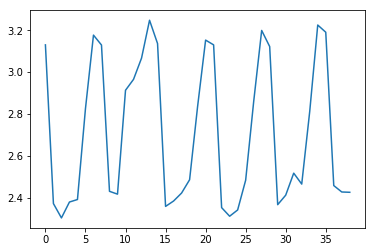

In [ ]:
plt.plot(testpreds[129])

In [ ]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [ ]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.808057   
air_0164b9927d20bcc3_2017-04-23              1.474079   
air_0241aa3964b7f861_2017-04-23              2.367617   
air_0328696196e46f18_2017-04-23              2.111135   
air_034a3d5b40d5b1b1_2017-04-23              3.521095   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.098589  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.367012  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.671934  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.257612  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.821453

In [ ]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [ ]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [ ]:
submission.to_csv("../submission/l4_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')